In [1]:
%pip install torchvision
%pip install matplotlib
%pip install scipy
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import os
import scipy
from torchvision import datasets, transforms
from torch import optim, nn, unsqueeze
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)), transforms.Grayscale(num_output_channels=1)])

# with data augmentation for training only
train_transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor(),
                                    # transforms.ToPILImage(),
                                    # transforms.CenterCrop(21),
                                    transforms.RandomRotation(30),
                                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                    # transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                    transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset0 = datasets.ImageFolder('/Users/enrico/Downloads/mnist-varres/train', transform=transform)
testset = datasets.ImageFolder('/Users/enrico/Downloads/mnist-varres/test', transform=transform)

# Also create a validation set 
trainset, valset = train_test_split(trainset0, test_size=10000, random_state=42)
#pytorch alternative for spliting into train and validation sets
#https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [5]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([16, 1, 28, 28])
torch.Size([16])


In [10]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()

        self.conv_neural_network_layers = nn.Sequential(
                # output_sizeOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1

                # We have in_channels=1 because our input is a grayscale image
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2), 

                # output of second conv layer
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2), 

                # output of third conv layer
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2) )

        # Linear layer
        self.linear_layers = nn.Sequential(
                nn.Linear(64*3*3, 10))
                # nn.Linear(16, 10)) # The output is 10 which should match the size of our class


    # Defining the forward pass 
    def forward(self, x):
        x = self.conv_neural_network_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        x = torch.flatten(x, 1) # same as x = x.view(x.size(0), -1)
        # Then pass it through the linear layer
        x = self.linear_layers(x)

        return x

model = Network()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y_hot = F.one_hot(y, 10)
        y_hot = torch.zeros(batch_size, 10)
        y_hot[range(y_hot.shape[0]), y]=1      

        X, y_hot = X.to(device), y_hot.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y_hot)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return loss

#We also check the model’s performance against the test dataset to ensure it is learning.

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        y_hot = F.one_hot(y, 10)
        y_hot = torch.zeros(batch_size, 10)
        y_hot[range(y_hot.shape[0]), y]=1      

        X, y_hot = X.to(device), y_hot.to(device)

        # Compute prediction error
        pred = model(X)
        test_loss += loss_fn(pred, y_hot).item()
        correct += (pred.argmax(axis=1) == y_hot.argmax(axis=1)).type(torch.float).sum().item()

    test_loss /= 10000
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100*correct


## Experiments

In [11]:
epochs = 5

mmp_train_loss = []
mmp_loss = []
mmp_acc = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainloader, model, loss_fn, optimizer)
    mmp_train_loss.append(train_loss)
    loss, acc = test(valloader, model, loss_fn)
    mmp_loss.append(loss)
    mmp_acc.append(acc)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 93.1%, Avg loss: 0.003168 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.002115 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.001959 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 96.8%, Avg loss: 0.001560 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.001380 

Done!


In [12]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)), transforms.Grayscale(num_output_channels=1)])

# with data augmentation for training only
train_transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor(),
                                    # transforms.ToPILImage(),
                                    # transforms.CenterCrop(21),
                                    transforms.RandomRotation(30),
                                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                    # transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                    transforms.Normalize((0.5,), (0.5,)), transforms.Grayscale(num_output_channels=1)])

# Download and load the training data
trainset0 = datasets.ImageFolder('/Users/enrico/Downloads/mnist-varres/train', transform=train_transform)
testset = datasets.ImageFolder('/Users/enrico/Downloads/mnist-varres/test', transform=transform)

# Also create a validation set 
trainset, valset = train_test_split(trainset0, test_size=10000, random_state=42)
#pytorch alternative for spliting into train and validation sets
#https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [13]:
model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
epochs = 5

mmxp_train_loss = []
mmxp_loss = []
mmxp_acc = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainloader, model, loss_fn, optimizer)
    mmxp_train_loss.append(train_loss)
    loss, acc = test(valloader, model, loss_fn)
    mmxp_loss.append(loss)
    mmxp_acc.append(acc)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.006425 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 88.4%, Avg loss: 0.004779 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 89.6%, Avg loss: 0.004210 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.003927 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 91.5%, Avg loss: 0.003699 

Done!


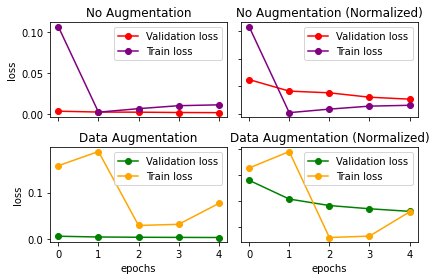

In [18]:
#plot all in one fig
fig, axs = plt.subplots(2, 2)

mmp_train_losses = [loss.detach().numpy() for loss in mmp_train_loss]
mmxp_train_losses = [loss.detach().numpy() for loss in mmxp_train_loss]

normed_mmp_train_losses = [i/sum(mmp_train_losses) for i in mmp_train_losses]
normed_mmp_val_losses = [i/sum(mmp_loss) for i in mmp_loss]

normed_mmxp_train_losses = [i/sum(mmxp_train_losses) for i in mmxp_train_losses]
normed_mmxp_val_losses = [i/sum(mmxp_loss) for i in mmxp_loss]

axs[0,0].plot(mmp_loss, '-o',label="Validation loss", color='red')
axs[0,0].plot(mmp_train_losses,'-o', label="Train loss",  color='purple')
axs[0,0].set_title("No Augmentation")
axs[0,0].legend()

axs[0,1].plot(normed_mmp_val_losses,'-o', label="Validation loss",  color='red')
axs[0,1].plot(normed_mmp_train_losses, '-o',label="Train loss",  color='purple')
axs[0,1].set_title("No Augmentation (Normalized)")
axs[0,1].legend()

axs[1,0].plot(mmxp_loss, '-o',label="Validation loss",  color='green')
axs[1,0].plot(mmxp_train_losses, '-o',label="Train loss",  color='orange')
axs[1,0].set_title("Data Augmentation")
axs[1,0].legend()

axs[1,1].plot(normed_mmxp_val_losses, '-o',label="Validation loss",  color='green')
axs[1,1].plot(normed_mmxp_train_losses, '-o',label="Train loss",  color='orange')
axs[1,1].set_title("Data Augmentation (Normalized)")
axs[1,1].legend()

for ax in axs.flat:
    ax.set(xlabel='epochs', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.tight_layout()